In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [11]:
train_path = 'Data_Manually_Cleaned/train'
val_path = 'Data_Manually_Cleaned/valid'


classN_train_path = train_path + "/normal/"
classA_train_path = train_path + "/adenocarcinoma/"
classL_train_path = train_path + "/large.cell.carcinoma/"
classS_train_path = train_path + "/squamous.cell.carcinoma/"
classN_valid_path = val_path + "/normal/"
classA_valid_path = val_path + "/adenocarcinoma/"
classL_valid_path = val_path + "/large.cell.carcinoma/"
classS_valid_path = val_path + "/squamous.cell.carcinoma/"

In [12]:
mean_sizes = []

print("CLASS: NORMAL")
mean_sizes.append(get_average_image_size(classN_train_path)[0])

print("\nCLASS: A")
mean_sizes.append(get_average_image_size(classA_train_path)[0])

print("\nCLASS: L")
mean_sizes.append(get_average_image_size(classL_train_path)[0])

print("\nCLASS: S")
mean_sizes.append(get_average_image_size(classS_train_path)[0])

CLASS: NORMAL
n7 (2) - Copy.png corrupt
n7 - Copy.png corrupt
n7 (2).png corrupt
n7.png corrupt
Average Image Sizes
    mean:   (428.72222222222223, 571.4722222222222)
    median: (475.0, 562.0)

CLASS: A
Average Image Sizes
    mean:   (258.26666666666665, 385.574358974359)
    median: (256.0, 388.0)

CLASS: L
Average Image Sizes
    mean:   (259.7391304347826, 398.5304347826087)
    median: (261.0, 406.0)

CLASS: S
Average Image Sizes
    mean:   (271.3806451612903, 396.5032258064516)
    median: (274.0, 404.0)


In [13]:
mean_sizes = np.array(mean_sizes)
out_img_size = (int(np.round(mean_sizes[:, 0].mean())), int(np.round(mean_sizes[:, 1].mean())))

print(f"Mean of all images: {out_img_size}")

Mean of all images: (305, 438)


In [14]:
out_img_dir = "Data_Cropped_and_Resized"
output_img_size = (256, 256)

crop_and_resize_images(train_path, output_img_size, out_img_dir)

In [15]:
crop_and_resize_images(val_path, output_img_size, out_img_dir)


### Define class labels

In [16]:
class_mappings = {
    0: "normal",
    1: "adenocarcinoma",
    2: "large.cell.carcinoma",
    3: "squamous.cell.carcinoma"
}

### Feature Extraction

In [25]:
#train_path = "/content/drive/MyDrive/W281/Final Project/Data_Resized/train"
train_path = 'Data_Cropped_and_Resized/train'
train_imgs, train_sobel_edges, train_labels = extract_features(train_path, detect_edges_sobel, class_mappings)
_, train_hounsfield_edges, _ = extract_features(train_path, apply_hounsfield_units, class_mappings)

In [18]:
valid_path = "Data_Cropped_and_Resized/valid"
valid_imgs, valid_sobel_edges, valid_labels = extract_features(valid_path, detect_edges_sobel, class_mappings)
_, valid_hounsfield_edges, _ = extract_features(valid_path, apply_hounsfield_units, class_mappings)

### Plot features

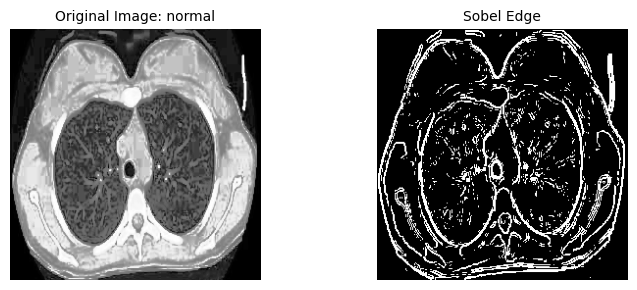

In [27]:
plot_features(train_imgs, train_sobel_edges, train_labels, 0, 'Sobel Edge', class_mappings)

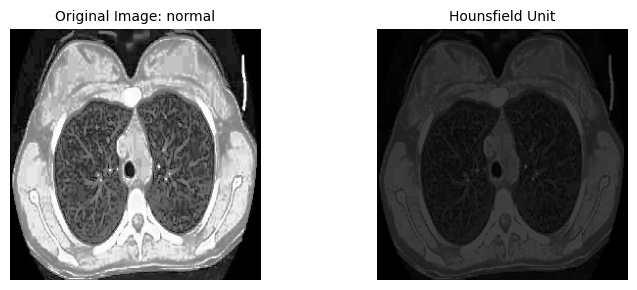

In [28]:
plot_features(train_imgs, train_hounsfield_edges, train_labels, 0, "Hounsfield Unit", class_mappings)

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC


def get_PCA(X_list, n_components=2):
  pca_list = []
  xpca_list = []
  for X in X_list:
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
    X_pca = pca.transform(X)
    pca_list.append(pca)
    xpca_list.append(X_pca)
  return pca_list, xpca_list

def plot_PCA(X_list, labels, n_components=2):
  pca_list, xpca_list = get_PCA(X_list, n_components=n_components)

  plt.figure(figsize=(15,5))
  colors = ['b-', 'm-']
  for i in range(len(X_list)):
    plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
  plt.xticks(np.arange(n_components)+1)
  plt.yticks(np.linspace(0, 1, 8))
  plt.grid(True)
  plt.xlabel('Number of components')
  plt.ylabel('Explained Variances')
  plt.legend()
  plt.show()

def get_tsne(X_list, n_components=2):
  xtsne_list = []
  for X in X_list:
    tsne = TSNE(n_components=n_components, random_state=0)
    X_tsne = tsne.fit_transform(X)
    xtsne_list.append(X_tsne)
  return xtsne_list

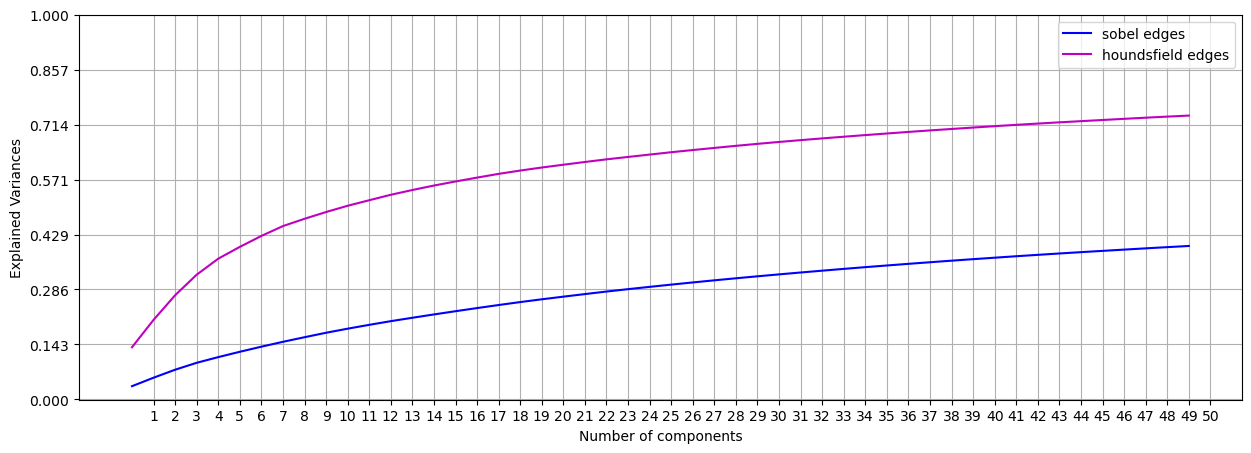

In [36]:

labels = ['sobel edges', 'houndsfield edges']

training_features = [[img.flatten() for img in train_sobel_edges],
            [img.flatten() for img in train_hounsfield_edges]]

x = plot_PCA(training_features, labels, n_components=50)

In [40]:

X_sobel_pca, X_hounsfield_pca = get_PCA(training_features, n_components=48)[-1]



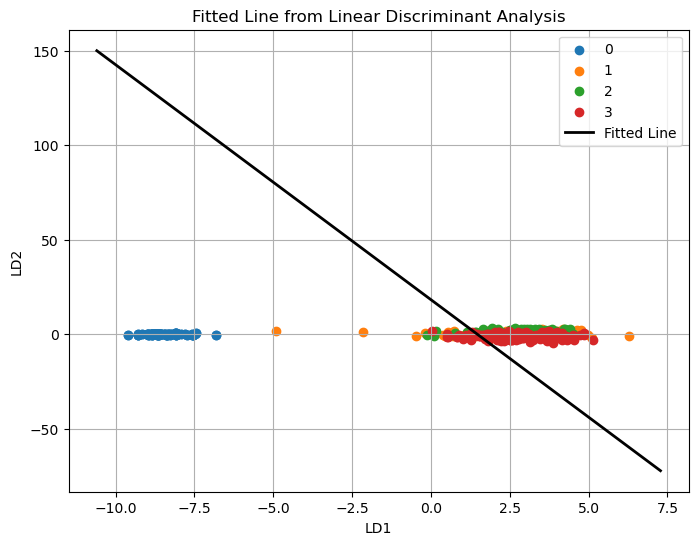

In [43]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_sobel_pca, train_labels)

X_lda = lda.transform(X_sobel_pca)

coef_lda = lda.coef_[0]
intercept_lda = lda.intercept_[0]

plt.figure(figsize=(8, 6))

for label in np.unique(train_labels):
    plt.scatter(X_lda[train_labels == label, 0], X_lda[train_labels == label, 1], label=label)

x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
line_x = np.array([x_min, x_max])
line_y = -(line_x * coef_lda[0] + intercept_lda) / coef_lda[1]

plt.plot(line_x, line_y, c='black', linewidth=2, label='Fitted Line')

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Fitted Line from Linear Discriminant Analysis')
plt.legend()
plt.grid(True)
plt.show()

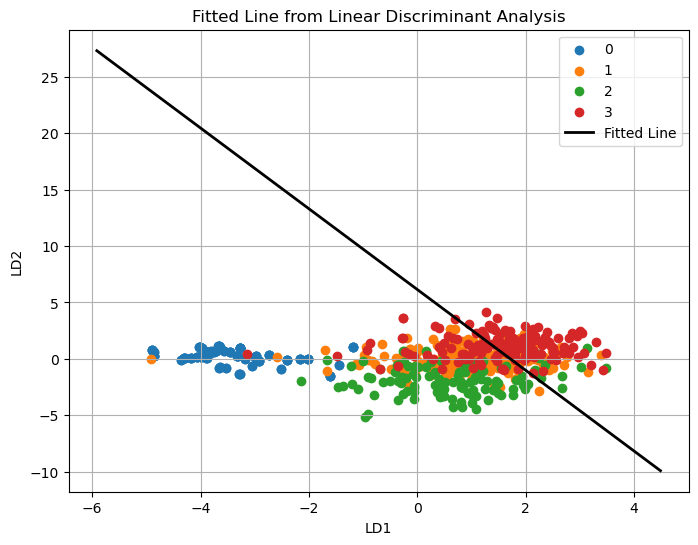

In [45]:

lda = LinearDiscriminantAnalysis()
lda.fit(X_hounsfield_pca, train_labels)

X_lda = lda.transform(X_hounsfield_pca)

coef_lda = lda.coef_[0]
intercept_lda = lda.intercept_[0]

plt.figure(figsize=(8, 6))

for label in np.unique(train_labels):
    plt.scatter(X_lda[train_labels == label, 0], X_lda[train_labels == label, 1], label=label)

x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
line_x = np.array([x_min, x_max])
line_y = -(line_x * coef_lda[0] + intercept_lda) / coef_lda[1]

plt.plot(line_x, line_y, c='black', linewidth=2, label='Fitted Line')

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Fitted Line from Linear Discriminant Analysis')
plt.legend()
plt.grid(True)
plt.show()